<a href="https://colab.research.google.com/github/SeongminCC/segmentation_/blob/main/UNet_ISBI_2012.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

참고링크 : https://dacon.io/codeshare/4245

#모듈 import

In [ ]:
import os
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from torchvision.transforms.functional import pad

# 데이터 불러오기

In [ ]:
%cd /content/drive/MyDrive/segmentation_project/U-Net/Model/ISBI_2012_EM
!ls -al

/content/drive/MyDrive/segmentation_project/U-Net/Model/ISBI_2012_EM
total 60
drwx------ 2 root root  4096 Aug 23 13:43 data
-rw------- 1 root root     0 Aug 27 08:11 first_batch_input.jpg
-rw------- 1 root root 52360 Aug 27 08:11 first_batch_label.jpg
drwx------ 2 root root  4096 Aug 31 10:39 Log


In [ ]:
dir_data = './data'
log_path = './Log'

name_label = 'train-labels.tif'
name_input = 'train-volume.tif'

img_label = Image.open(os.path.join(dir_data, name_label))
img_input = Image.open(os.path.join(dir_data, name_input))

ny, nx = img_label.size
nframe = img_label.n_frames

print(ny, nx)
print(nframe)

512 512
30


#training, validation, test 이미지 데이터 개수 정해주기

In [ ]:
nframe_train = 24
nframe_val = 3
nframe_test = 3

dir_save_train_input = os.path.join(dir_data, 'train/input')
dir_save_train_label = os.path.join(dir_data, 'train/label')

dir_save_val_input = os.path.join(dir_data, 'val/input')
dir_save_val_label = os.path.join(dir_data, 'val/label')

dir_save_test_input = os.path.join(dir_data, 'test/input')
dir_save_test_label = os.path.join(dir_data, 'test/label')

#512x512x30 에서 선별할 frame shuffle해서 추출하기

In [ ]:
id_frame = np.arange(nframe)
np.random.shuffle(id_frame)

#24개의 training data(input, label)를 추출하기

In [ ]:
offset_nframe = 0

for i in range(nframe_train):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    # tif 파일로 저장
    # img_label.save(os.path.join(dir_save_train_label, 'label_%03d.tif' % i))
    # img_input.save(os.path.join(dir_save_train_input, 'input_%03d.tif' % i))

    # np.save('filename.npy', array) 를 이용하여 NPY파일로 배열을 내보낼 수 있음
    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_train_label, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_train_input, 'input_%03d.npy' % i), input_)

#3개의 validation data(input, label)를 추출하기

In [ ]:
offset_nframe = nframe_train

for i in range(nframe_val):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_val_label, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_val_input, 'input_%03d.npy' % i), input_)


#3개의 test data(input, label) 를 추출하기

In [ ]:
offset_nframe = nframe_train + nframe_val

for i in range(nframe_test):
    img_label.seek(id_frame[i + offset_nframe])
    img_input.seek(id_frame[i + offset_nframe])

    label_ = np.asarray(img_label)
    input_ = np.asarray(img_input)

    np.save(os.path.join(dir_save_test_label, 'label_%03d.npy' % i), label_)
    np.save(os.path.join(dir_save_test_input, 'input_%03d.npy' % i), input_)


# 이미지 시각화

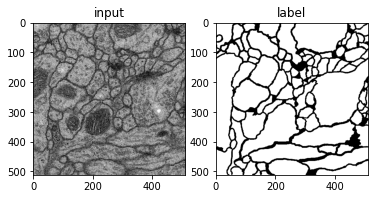

In [ ]:
plt.subplot(121)
plt.imshow(input_, cmap='gray')
plt.title('input')

plt.subplot(122)
plt.imshow(label_, cmap='gray')
plt.title('label')

plt.show()

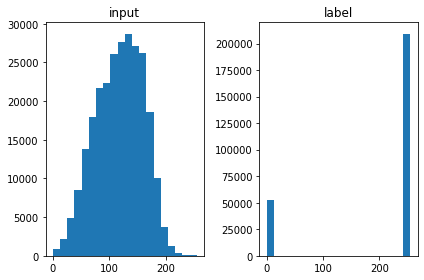

In [ ]:
plt.subplot(121)
plt.hist(input_.flatten(), bins=20)
plt.title('input')

plt.subplot(122)
plt.hist(label_.flatten(), bins=20)
plt.title('label')

plt.tight_layout()
plt.show()

# 신경망 구축 (U-Net)

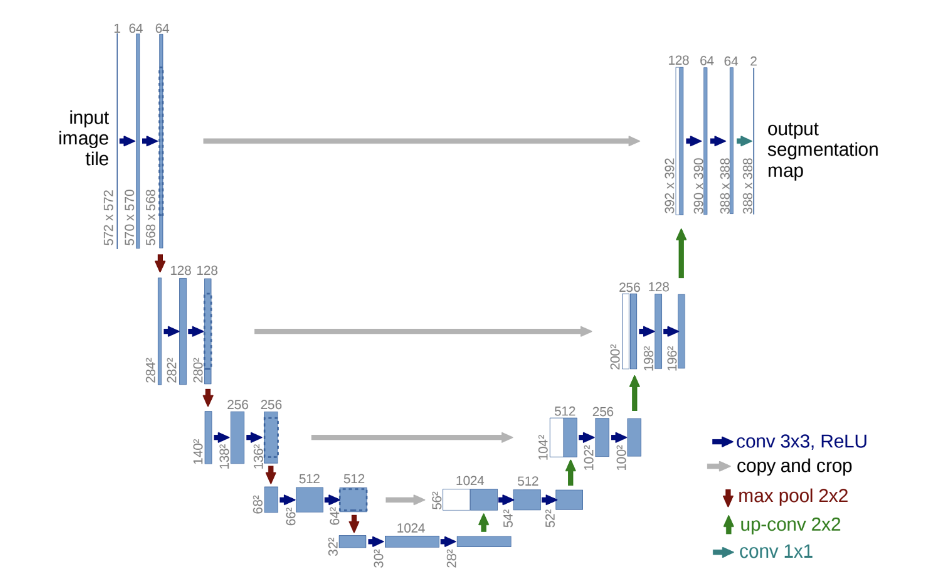

In [ ]:
## 라이브러리
import os
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt

from torchvision import transforms, datasets

## 네트워크 구축하기
class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # Convolution + BatchNormalization + Relu 정의하기
        def CBR2d(in_channels, out_channels, kernel_size=3, stride=1, padding='same', bias=True): 
            layers = []
            layers += [nn.Conv2d(in_channels=in_channels, out_channels=out_channels,
                                 kernel_size=kernel_size, stride=stride, padding=padding,
                                 bias=bias)]
            layers += [nn.BatchNorm2d(num_features=out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)

            return cbr

        # 수축 경로(Contracting path)
        # (512, 512, 1)
        self.enc1_1 = CBR2d(in_channels=1, out_channels=64)  
        # (512, 512, 64)
        self.enc1_2 = CBR2d(in_channels=64, out_channels=64)  
        # (512, 512, 64)
        self.pool1 = nn.MaxPool2d(kernel_size=2)  
        # (256, 256, 64)


        self.enc2_1 = CBR2d(in_channels=64, out_channels=128)  
        # (256, 256, 128)
        self.enc2_2 = CBR2d(in_channels=128, out_channels=128) 
        # (256, 256, 128)
        self.pool2 = nn.MaxPool2d(kernel_size=2)  
        # (128, 128, 128)


        self.enc3_1 = CBR2d(in_channels=128, out_channels=256)  
        # (128, 128, 256)
        self.enc3_2 = CBR2d(in_channels=256, out_channels=256)  
        # (128, 128, 256)
        self.pool3 = nn.MaxPool2d(kernel_size=2)  
        # (64, 64, 256)


        self.enc4_1 = CBR2d(in_channels=256, out_channels=512)  
        # (64, 64, 512) 
        self.enc4_2 = CBR2d(in_channels=512, out_channels=512)
        # (64, 64, 512)
        self.pool4 = nn.MaxPool2d(kernel_size=2)
        # (32, 32, 512)


        self.enc5_1 = CBR2d(in_channels=512, out_channels=1024)
        # (32, 32, 1024)


#############################################################################################
        # 확장 경로(Expansive path)
        self.dec5_1 = CBR2d(in_channels=1024, out_channels=512)
        # (32, 32, 512)
        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                          kernel_size=2, stride=2, padding=0, bias=True)
        # (64, 64, 512)
        self.dec4_2 = CBR2d(in_channels=2 * 512, out_channels=512)
        # (64, 64, 512)
        self.dec4_1 = CBR2d(in_channels=512, out_channels=256)

        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec3_2 = CBR2d(in_channels=2 * 256, out_channels=256)
        self.dec3_1 = CBR2d(in_channels=256, out_channels=128)

        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec2_2 = CBR2d(in_channels=2 * 128, out_channels=128)
        self.dec2_1 = CBR2d(in_channels=128, out_channels=64)

        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                          kernel_size=2, stride=2, padding=0, bias=True)

        self.dec1_2 = CBR2d(in_channels=2 * 64, out_channels=64)
        self.dec1_1 = CBR2d(in_channels=64, out_channels=64)

        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    # forward 함수 정의하기
    def forward(self, x):
        enc1_1 = self.enc1_1(x)
        enc1_2 = self.enc1_2(enc1_1)
        pool1 = self.pool1(enc1_2)

        enc2_1 = self.enc2_1(pool1)
        enc2_2 = self.enc2_2(enc2_1)
        pool2 = self.pool2(enc2_2)

        enc3_1 = self.enc3_1(pool2)
        enc3_2 = self.enc3_2(enc3_1)
        pool3 = self.pool3(enc3_2)

        enc4_1 = self.enc4_1(pool3)
        enc4_2 = self.enc4_2(enc4_1)
        pool4 = self.pool4(enc4_2)

        enc5_1 = self.enc5_1(pool4)

        dec5_1 = self.dec5_1(enc5_1)

        unpool4 = self.unpool4(dec5_1)
        cat4 = torch.cat((unpool4, enc4_2), dim=1)
        dec4_2 = self.dec4_2(cat4)
        dec4_1 = self.dec4_1(dec4_2)

        unpool3 = self.unpool3(dec4_1)
        cat3 = torch.cat((unpool3, enc3_2), dim=1)
        dec3_2 = self.dec3_2(cat3)
        dec3_1 = self.dec3_1(dec3_2)

        unpool2 = self.unpool2(dec3_1)
        cat2 = torch.cat((unpool2, enc2_2), dim=1)
        dec2_2 = self.dec2_2(cat2)
        dec2_1 = self.dec2_1(dec2_2)

        unpool1 = self.unpool1(dec2_1)
        cat1 = torch.cat((unpool1, enc1_2), dim=1)
        dec1_2 = self.dec1_2(cat1)
        dec1_1 = self.dec1_1(dec1_2)

        x = self.fc(dec1_1)

        return x

In [ ]:
print(torch.cuda.is_available())
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
net = UNet()
net = net.to(device)
print(net)

True
cuda
UNet(
  (enc1_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc1_2): Sequential(
    (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (enc2_1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (enc2_2): Sequential(
    (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, c

# DataLoader 및 Transform 정의하기

In [ ]:
import os
import numpy as np
import torch
import torch.nn as nn

In [ ]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, data_dir, transform=None, seed=None):
        self.data_dir = data_dir
        self.transform = transform   # 데이터 전처리
        self.seed = seed
        

        self.data_dir_input = self.data_dir + '/input'
        self.data_dir_label = self.data_dir + '/label'

        lst_data_input = os.listdir(self.data_dir_input)
        lst_data_label = os.listdir(self.data_dir_label)

        self.lst_input = lst_data_input
        self.lst_label = lst_data_label

    def __len__(self):
        return len(self.lst_label)

    def __getitem__(self, index):
        label = np.load(os.path.join(self.data_dir_label, self.lst_label[index]))  # 해당 index에 부합하는 경로의 데이터를 np.load 한다.
        input = np.load(os.path.join(self.data_dir_input, self.lst_input[index]))  # np.load : np.save로 저장된 .npy파일을 배열로 불러옴

        # 데이터와 label이 2차원 행렬일 경우 파이토치에 수행하기 위해 3차원 텐서로 변형한다.
        if label.ndim == 2:
            label = label[:, :, np.newaxis]
        if input.ndim == 2:
            input = input[:, :, np.newaxis]

        data = {'input':input, 'label':label}

        if self.transform:
            torch.manual_seed(self.seed)
            data['input'] = self.transform(data['input'])

        if self.transform:
            torch.manual_seed(self.seed)
            data['label'] = self.transform(data['label'])

        return data

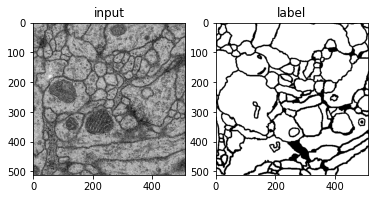

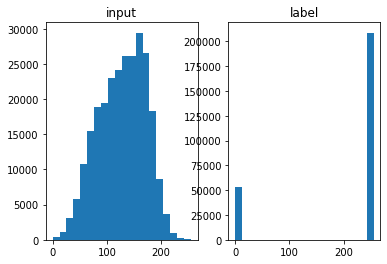

In [ ]:
# 데이터로더 잘 구현되었는지 확인
dataset_train = Dataset(data_dir=dir_data + '/train', seed=10)

data = dataset_train.__getitem__(0) 
input = data['input']
label = data['label']

# 불러온 이미지 시각화
plt.subplot(122)
plt.imshow(label.reshape(512, 512), cmap='gray')
plt.title('label')

plt.subplot(121)
plt.imshow(input.reshape(512, 512), cmap='gray')
plt.title('input')

plt.show()


plt.subplot(121)
plt.hist(input.flatten(), bins=20)
plt.title('input')

plt.subplot(122)
plt.hist(label.flatten(), bins=20)
plt.title('label')
plt.show()

# 네트워크 훈련

In [ ]:
import os
import numpy as np

import torch 
import torch.nn as nn
from torch.utils.data import DataLoader

import time

from torchvision import transforms

import copy
from torchvision.utils import save_image

In [ ]:
data_dir = 'data'
batch_size = 1
data_load_seed = 10

# 전처리
transform_train = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

transform_val = transforms.Compose([
    transforms.ToPILImage(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=0.5, std=0.5)
])

# train, val 데이터셋과 데이터로드 정의
dataset_train = Dataset(data_dir=os.path.join(data_dir, 'train'), transform=transform_train, seed=data_load_seed)
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False, num_workers=0)

dataset_val = Dataset(data_dir=os.path.join(data_dir, 'val'), transform=transform_val, seed=data_load_seed)
loader_val = DataLoader(dataset_val, batch_size=batch_size, shuffle=False, num_workers=0)

# 데이터 개수
num_data_train = len(dataset_train)
num_data_val = len(dataset_val)

num_batch_train = np.ceil(num_data_train / batch_size)
num_batch_val = np.ceil(num_data_val / batch_size)

# 네트워크 생성
net=UNet().to(device)

# 손실함수 정의
fn_loss = nn.BCEWithLogitsLoss().to(device)

# Optimizer 정의
optimizer = torch.optim.Adam(net.parameters(), lr=1e-3)

# 네트워크 학습
st_epoch = 0
num_epoch = 30

# file명 정의
file_name = './Log/UNet15.pth'

# model_train(val)
def train_model(net, fn_loss, optimizer, num_epoch):
    since = time.time()

    best_model_wts = copy.deepcopy(net.state_dict())
    best_loss = 100

    for epoch in range(st_epoch + 1, num_epoch + 1):
        net.train()
        loss_arr = []

        for batch, data in enumerate(loader_train, 1):
            # denormalization : label은 0과 1로만 이루어져야함
            data['label'] = data['label'] * 0.5 + 0.5  
            label = data['label']
            input = data['input']
            # torch tensor 에서 바로 이미지 저장을 하기 위한 함수 : torchvision.utils에서 제공하는 save_image()
            ##########################################################################################################
            # first_batch_input = input[0]*0.5 + 0.5
            # save_image(first_batch_input, 'first_batch_input.jpg')

            # first_batch_label = label[0]*0.5 + 0.5
            # save_image(first_batch_label, 'first_batch_label.jpg')
            # 
            ##########################################################################################################

            # forward pass
            label = data['label'].to(device)
            input = data['input'].to(device)

            output = net(input)

            # backward pass
            optimizer.zero_grad()

            loss = fn_loss(output, label)
            loss.backward()

            optimizer.step()

            # 손실함수 계산
            loss_arr += [loss.item()]

            print("TRAIN: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_train, np.mean(loss_arr)))
            
        with torch.no_grad():
            net.eval()
            loss_arr = []
            
            for batch, data in enumerate(loader_val, 1):
                data['label'] = data['label'] * 0.5 + 0.5 # denormalization -> X*std+mean

                # forward pass
                label = data['label'].to(device)
                input = data['input'].to(device)

                ouput = net(input)

                # 손실함수 계산하기
                loss = fn_loss(output, label)

                loss_arr += [loss.item()]

                print("VALID: EPOCH %04d / %04d | BATCH %04d / %04d | LOSS %.4f" %
                  (epoch, num_epoch, batch, num_batch_val, np.mean(loss_arr)))
            
            epoch_loss = np.mean(loss_arr)

            # deep copy the model
            if epoch_loss < best_loss:
                best_loss = epoch_loss
                best_model_wts = copy.deepcopy(net.state_dict())

        print()
    
    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60
    ))
    print('Best val loss: {:4f}'.format(best_loss))

    # load best model weights
    net.load_state_dict(best_model_wts)
    return net

if __name__ == '__main__':
    model_ft = train_model(net, fn_loss, optimizer, num_epoch)
    torch.save(model_ft.state_dict(), file_name)
    

TRAIN: EPOCH 0001 / 0030 | BATCH 0001 / 0024 | LOSS 0.7539
TRAIN: EPOCH 0001 / 0030 | BATCH 0002 / 0024 | LOSS 0.8628
TRAIN: EPOCH 0001 / 0030 | BATCH 0003 / 0024 | LOSS 0.8187
TRAIN: EPOCH 0001 / 0030 | BATCH 0004 / 0024 | LOSS 0.7748
TRAIN: EPOCH 0001 / 0030 | BATCH 0005 / 0024 | LOSS 0.7415
TRAIN: EPOCH 0001 / 0030 | BATCH 0006 / 0024 | LOSS 0.7086
TRAIN: EPOCH 0001 / 0030 | BATCH 0007 / 0024 | LOSS 0.6863
TRAIN: EPOCH 0001 / 0030 | BATCH 0008 / 0024 | LOSS 0.6619
TRAIN: EPOCH 0001 / 0030 | BATCH 0009 / 0024 | LOSS 0.6756
TRAIN: EPOCH 0001 / 0030 | BATCH 0010 / 0024 | LOSS 0.6525
TRAIN: EPOCH 0001 / 0030 | BATCH 0011 / 0024 | LOSS 0.6556
TRAIN: EPOCH 0001 / 0030 | BATCH 0012 / 0024 | LOSS 0.6407
TRAIN: EPOCH 0001 / 0030 | BATCH 0013 / 0024 | LOSS 0.6267
TRAIN: EPOCH 0001 / 0030 | BATCH 0014 / 0024 | LOSS 0.6161
TRAIN: EPOCH 0001 / 0030 | BATCH 0015 / 0024 | LOSS 0.6047
TRAIN: EPOCH 0001 / 0030 | BATCH 0016 / 0024 | LOSS 0.5933
TRAIN: EPOCH 0001 / 0030 | BATCH 0017 / 0024 | LOSS 0.59